In [ ]:
!nvidia-smi

In [4]:
import pandas as pd
import numpy as np
import cv2
import torch
from PIL import Image
import os

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


In [5]:
def show_image_distribution(image_path):
  image_sizes = []
  for file in os.listdir(image_path):
      img = Image.open(os.path.join(image_path, file))
      image_sizes.append(img.size)

  plt.hist(image_sizes)

  plt.title('Training Data Image Size Distribution')
  plt.xlabel('Image Size')
  plt.ylabel('Count')


  plt.show()

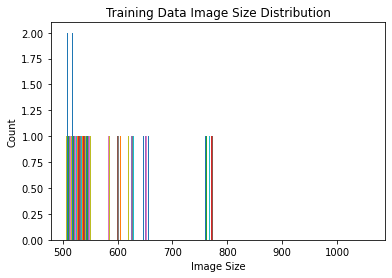

In [6]:
show_image_distribution('/content/train')

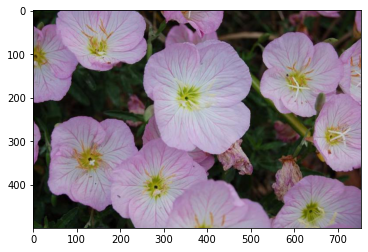

In [7]:
df = pd.read_csv('train.csv')
img_path = df['file_path'][0]
img = Image.open('/content/' + img_path)
plt.imshow(img)

In [85]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

mean_vgg = [0.485, 0.456, 0.406]
std_vgg = [0.229, 0.224, 0.225]

batch_size = 256

# Define the paths to the CSV file and image folder
train_df = pd.read_csv('train.csv')
img_folder_path = '/content/'


image_size = (256, 256)

train_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_vgg, std_vgg)
])

val_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_vgg, std_vgg)
]) 


class FlowerDataset(Dataset):
    def __init__(self, data, img_folder_path, transform=None):
        self.data = data
        self.img_folder_path = img_folder_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path = self.data['file_path'].iloc[index]
        img = Image.open(self.img_folder_path + img_path).convert('RGB')
        label = self.data['label'].iloc[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)


train_dataset = FlowerDataset(train_data, img_folder_path, train_transform)
val_dataset = FlowerDataset(val_data, img_folder_path, val_transform)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


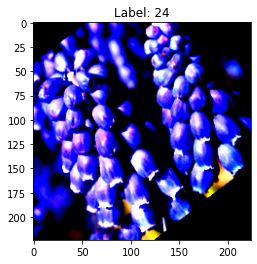

In [9]:

sample_index = 10  
sample = train_dataset[sample_index]
val_sample = val_dataset[sample_index]


image = sample[0]
label = sample[1]

val_image = val_sample[0]
val_label = val_sample[1]

image_np = image.permute(1, 2, 0).numpy()
val_image_np = val_image.permute(1, 2, 0).numpy()

plt.imshow(image_np)
plt.title(f"Label: {label}")

plt.show()


Text(0.5, 1.0, 'Val_Label: 50')

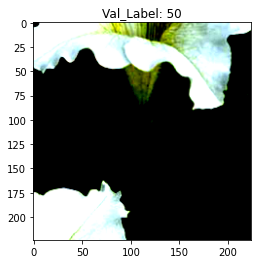

In [10]:
plt.imshow(val_image_np)
plt.title(f"Val_Label: {val_label}")

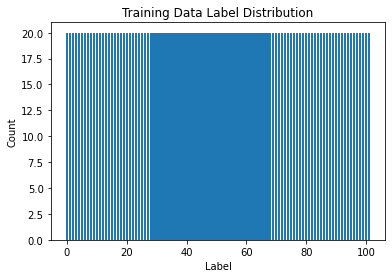

In [ ]:
label_counts = train_df['label'].value_counts()

plt.bar(label_counts.index, label_counts.values)

plt.title('Training Data Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Display the bar chart
plt.show()

In [ ]:
# batch_size = 64
# train_dataset = TensorDataset(images,labels)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16]) torch.int64


In [12]:
num_classes = train_df['label'].unique()

print(num_classes)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  20  16
  17  18  19  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]


In [ ]:
## PRETRAINED MODEL 1

In [ ]:
import torchvision.models as models
#add pretrained model
num_classes = 102

#pretrained model 1
pretrained = models.resnet50(pretrained=True)

#Load the pretrained model and remove the final layer
features = pretrained.fc.in_features
pretrained.fc = nn.Identity()

layers = nn.Sequential(
    nn.Linear(features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

#Freeze the pre-trained layers
for param in pretrained.parameters():
    param.requires_grad = False


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
## PRETRAINED MODEL 2
import torchvision.models as models
#add pretrained model
num_classes = 102

#pretrained model 2
pretrained2 = models.vgg19(pretrained=True)


pretrained2.fc = nn.Identity()

layers2 = nn.Sequential(
    nn.Linear(1000, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim = 1)
)

#Freeze the pre-trained layers
for param in pretrained2.parameters():
    param.requires_grad = False

In [14]:
# PRETRAINED MODEL 3
import torchvision.models as models
#add pretrained model
num_classes = 102

pretrained3 = models.densenet161(pretrained= True)
#Freeze the pre-trained layers
for param in pretrained3.parameters():
    param.requires_grad = False
#Unfreze some of the layers
for param in pretrained3.features.denseblock4.parameters():
    param.requires_grad = True

num_ftrs = pretrained3.classifier.in_features

layers3 = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes),
    # nn.LogSoftmax(dim = 1) # uncoment for nll loss
)


pretrained3.classifier = layers3



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# model = nn.Sequential(pretrained3, layers2)
model = pretrained3
model = model.to(device)
model

Main training loop. densenet161 was fine-tuned for 600/800 epochs. No need to run. Thw pretrained model can be downloaded from here: https://drive.google.com/file/d/1bcC4FIC1ksbZvrm_TtlmGeMiI1Qf236t/view?usp=sharing

In [ ]:
# Save the model, optimizer, loss function, and scheduler
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss_fn': loss,
    'scheduler': scheduler.state_dict()
}
torch.save(checkpoint, '/content/chall_1_model.pt')

### Model can be downloaded from here: https://drive.google.com/file/d/1bcC4FIC1ksbZvrm_TtlmGeMiI1Qf236t/view?usp=sharing

In [13]:
!unzip /content/drive/MyDrive/Deep_Learning_COM3025/chall_1_DL.zip -d /

Archive:  /content/drive/MyDrive/Deep_Learning_COM3025/chall_1_DL.zip
  inflating: /content/chall_1_model.pt  


In [99]:
# custom loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss



Fine-tune the pre-saved model for further 10 epochs

In [ ]:
import time

# Only run if more training nedded
checkpoint = torch.load('/content/chall_1_model.pt')
train_loss_list = []
val_loss_list = []


lr_max = 0.001


n_steps = len(train_dataloader)
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(alpha=1, gamma=2)

epochs = 10
# Extract the model, optimizer, loss function, and scheduler from the checkpoint
model.load_state_dict(checkpoint['model'])

# optimizer = torch.optim.Adam(model.features.denseblock4.parameters(), lr=0.001)

optimizer = torch.optim.AdamW(layers3.parameters(), lr=0.01, weight_decay=5e-2)
# optimizer.load_state_dict(checkpoint['optimizer'])


optimizer2 = torch.optim.Adam(model.features.denseblock4.parameters(), lr=0.001)

# optimizer2 = torch.optim.Adam(model.features.denseblock4.parameters(), lr=0.01, weight_decay=5e-2)



loss = checkpoint['loss_fn']

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_max, epochs=epochs, steps_per_epoch=n_steps)
scheduler.load_state_dict(checkpoint['scheduler'])


# scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optimizer2, max_lr=lr_max, epochs=epochs, steps_per_epoch=n_steps)



for epoch in range(epochs):
  
    start_time = time.time()
    model.train() 
    for i, (images, labels) in enumerate(train_dataloader,0):
       
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        optimizer2.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer2.step()
        
        
        # print('\tTraining batch {} Loss: {:.4f}'.format(i + 1, loss.item()))
        # print('traing_loss: ', training_loss)

        if (i+1) % n_steps == 0:
          train_loss_list.append(loss.item())
          end_time = time.time()
          # print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_steps}], training_loss: {loss.item():.4f}, Time: {end_time - start_time:.2f} seconds')
   
    model.eval() 
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_loss_list.append(val_loss)

    scheduler.step(val_loss)
    # scheduler2.step(val_loss)

    end_time = time.time()

    print(f'Epoch [{epoch+1}/{epochs}], training_loss: {train_loss_list[-1]:.4f}, validation_loss: {val_loss:.4f}, Time: {end_time - start_time:.2f} seconds')


plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
!zip -r /content/chall_1_DL.zip /content/chall_1_model.pt

  adding: content/chall_1_model.pt (deflated 5%)


In [ ]:
cp -r /content/chall_1_DL.zip /content/drive/MyDrive/Deep_Learning_COM3025

Accuracy: 94.85%


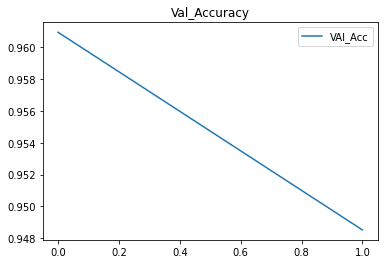

In [106]:
# TEST ACCURACY
correct = 0
total = 0
val_acc_list = []
model.eval()

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        val_acc_list.append(correct/total)

accuracy = correct / total
print('Accuracy: {:.2f}%'.format(accuracy * 100))

plt.plot(val_acc_list, label='VAl_Acc')
plt.title('Val_Accuracy')
plt.legend()
plt.show()

In [98]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
target_size = (256,256)
mean_vgg = [0.485, 0.456, 0.406]
std_vgg = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_vgg, std_vgg)
])



test_path = '/content/test/'
test_image_names = os.listdir(test_path)


predicted_labels = []
new_image_names = []



model.eval()
with torch.no_grad():

  for image_name in test_image_names:

      image = 'test/'+image_name
      new_image_names.append(image)
      img = Image.open(test_path + image_name).convert('RGB')
      img = test_transform(img)

      
      img = img.unsqueeze(0).to(device)
      output = model(img)
  
      _, predicted = torch.max(output.data, 1)

      predicted_labels.append(predicted.item())




predictions_dict = {'file_path': new_image_names, 'label': predicted_labels}

predictions_df = pd.DataFrame(predictions_dict)

# Write the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)


In [104]:
!python3 /usr/local/bin/kaggle competitions submit -m $URN -c com3025-2023-challenge1 -f predictions.csv

100% 294k/294k [00:02<00:00, 105kB/s]
Successfully submitted to COM3025-2023-Challenge1